# Testing centroid model

In [13]:
%config IPCompleter.use_jedi = False
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
from moffat import Moffat2D
import matplotlib.pyplot as plt

In [14]:
# Loading model
size = 15

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(size, size, 1), use_bias=True, padding="same"),
    layers.MaxPooling2D((2, 2), padding="same"),
    layers.Conv2D(128, (3, 3), activation='relu', use_bias=True, padding="same"),
    layers.MaxPooling2D((2, 2), padding="same"),
    layers.Conv2D(256, (3, 3), activation='relu', use_bias=True, padding="same"),
    layers.Flatten(),
    layers.Dense(2048, activation="sigmoid", use_bias=True),
    layers.Dense(512, activation="sigmoid", use_bias=True),
    layers.Dense(2),
])

model.load_weights("../../models/centroid.h5")

In [15]:
# Generating samples
moffats = Moffat2D(15)
images, labels = moffats.random_model_label(N=5000)

In [16]:
predictions = model(np.expand_dims(images, -1), training=False).numpy()

RMSE: 1.667e-02
Robustness: 99.98%


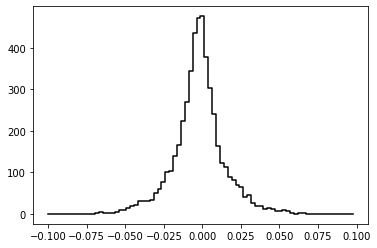

In [17]:
# plot
errors = labels - predictions
bins = np.linspace(-0.1, 0.1, 80)
histogram, _ = np.histogram(errors[:, 0], bins=bins)
plt.step(bins[0:-1], histogram, c="k")

# performances (<!> different distributions than in prose paper)
lim = 0.1
mask = np.max(np.abs(errors), 1) < 0.1
_errors = errors[mask]
print(f"RMSE: {np.sqrt(np.mean(_errors**2)):.3e}\nRobustness: {(1-(np.sum(~mask)/len(labels)))*100:.2f}%")

## Comparing centroid_2dg

In [110]:
from photutils import centroids
from tqdm import tqdm

In [117]:
predictions2dg = np.zeros_like(predictions)

for i, image in enumerate(tqdm(np.squeeze(images))):
    predictions2dg[i, :] = centroids.centroid_2dg(image)[::-1]

  0%|          | 18/5000 [00:00<04:02, 20.54it/s]/Users/lionelgarcia/Code/envs/prose/lib/python3.6/site-packages/astropy/modeling/fitting.py:894: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  AstropyUserWarning)
100%|██████████| 5000/5000 [04:09<00:00, 20.02it/s]


		ballet		centroid_2dg
RMSE:		1.681e-02	1.837e-02
Robustness:	99.98%		99.62%


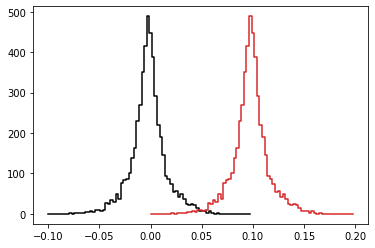

In [124]:
# plot
errors2 = labels - predictions2dg
histogram2, _ = np.histogram(errors[:, 0], bins=bins)
plt.step(bins[0:-1], histogram, c="k", label="ballet")
plt.step(bins[0:-1] + 0.1, histogram2, c="C3", label="centroid_2dg")

# errors
mask2 = np.max(np.abs(errors2), 1) < 0.1
_errors2 = errors2[mask2]
print(f"""\t\tballet\t\tcentroid_2dg
RMSE:\t\t{np.sqrt(np.mean(_errors**2)):.3e}\t{np.sqrt(np.mean(_errors2**2)):.3e}
Robustness:\t{(1-(np.sum(~mask)/len(labels)))*100:.2f}%\t\t{(1-(np.sum(~mask2)/len(labels)))*100:.2f}%""")